# Integer minimum cost flows with separable convex cost objective

The Problem of finding the most likely mulitpath split for a payment pair on the lightning network can be reduced to an **integer minimum cost flows with separable convex cost objective** and yields a polynomial solver c.f.: https://twitter.com/renepickhardt/status/1385144337907044352

This notebook tries to implement a solution given in the Textbook Network Flows Network Flows: Theory, Algorithms, and Applications by Ravindra K. Ahuja, Thomas L. Magnanti and James B. Orlin

This approach follows mainly chapter 9, 10.2 and 14.5 of the Textbook. 

Other good resources are the Lecture series http://courses.csail.mit.edu/6.854/20/ by David Karger (http://people.csail.mit.edu/karger/) with lecture notes at http://courses.csail.mit.edu/6.854/current/Notes/ and more specificially http://courses.csail.mit.edu/6.854/current/Notes/n09-mincostflow.html and the relevant subset of the recorded videos at this playlist: https://www.youtube.com/playlist?list=PLaRKlIqjjguDXlnJWG2T7U52iHZl8Edrcv

Other good resources are the lecture nodes by Hochbaum: https://hochbaum.ieor.berkeley.edu/

I did not find an open source implementation. Code for similar problems seems to be part of this library: https://github.com/frangio68/Min-Cost-Flow-Class but it seems to only allow quadratic cost functions. 

Following previous research ( https://arxiv.org/abs/2103.08576 ) our cost function is f(x) = log(c) - log(c-x) which turns out to be convex (f'(x) = 1/(c-x) and f"(x) = 1/(c-x)^2 from which we can see that f"(x) > 0)

In [2]:
import json
import networkx as nx
import math

log = math.log2

## some helpers for graphs

introduce some helper functions for handling graphs and importing out data structure / example

In [4]:
def import_channel_graph():
    """
    parses the channel_graph from the c-lightning API. one coule just create a different function here to parse
    data from other implementations
    """
    # retrieve this by: lightning-cli listchannels > listchannels.json
    f = open("listchannels.json")
    jsn = json.load(f)
    G = nx.Graph()
    for channel in jsn["channels"]:
        src = channel["source"]
        dest = channel["destination"]
        #we divide capacities by 1000 to avoid float overflows. this means our solution will 
        cap = int(int(channel["satoshis"])/1000)
        sid = channel["short_channel_id"]
        #FIXME: this will ignore multiedges on the lightning network and assume just a graph without parallel channels
        #for our proof of concept this is ok However the augment_path function currently assumes that the residual
        # network has at most two edges in one direction per node pair which means that no multi edges are supported
        # fixing this is an engineering challange of handeling data and not a problem for the algorithm
        # Thus for better understandability we made the assumption of a graph without parallel channels at this point.
        G.add_edge(src,dest,cap=cap,sid=sid)
    return G

def next_hop(path):
    for i in range(1,len(path)):
        src = path[i-1]
        dest = path[i]
        yield (src,dest)
        
def path_str(path):
    it = path[0]
    if len(it)>5:
        it = it[:5]
    res = it
    for src, dest in next_hop(path):
        if len(dest)>5:
            dest = dest[:5]
        res += " {}".format(dest)
    return res

def print_residual(r,G,x):
    for i,j in G.edges():
        cap = G[i][j]["cap"]
        f = x[i][j]
        #print("src: {} dest: {} cap: {} flow: {}".format(i,j,cap,f))
        if r.has_edge(i,j):
            print(i,j,r[i][j])
        if r.has_edge(j,i):
            print(j,i,r[j][i])   

            
channel_graph = import_channel_graph()

G = nx.DiGraph()
G.add_edge("S","A",cap=2)
G.add_edge("S","X",cap=1)
G.add_edge("A","B",cap=2)
G.add_edge("X","B",cap=9)
G.add_edge("X","Y",cap=7)
G.add_edge("Y","D",cap=4)
G.add_edge("B","D",cap=4)

SRC = "03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df"
DEST = "022c699df736064b51a33017abfc4d577d133f7124ac117d3d9f9633b6297a3b6a"
FLOW = 700

In [5]:
def generate_null_flow(G):
    flow = {n:{} for n in G.nodes()}
    for u,v in G.edges():
        flow[u][v]=0
        flow[v][u]=0
    return flow

def cost(a,c):
    """returns the negative log probability for the success to deliver `a` satoshis through a channel of capacity `c`"""
    return log(c+1)-log(c+1-a)    




## Compute Detla residual network as a unit capacity network

this means that if an edge is in the residual network we can flow delta in the actual network and otherwise we can't

as the delta residual network only cares about reduced cost the fuction also gets the potentials passed

In [6]:
def compute_delta_residual_network(G,x,delta,pi,C=cost):
    """
    The delta residual network is returned as a multigraph. 
    Note that the delta residual network can be seen as a uni-capacity network. Thus all capacity values are set to 1
    
    for convenience a lot of information is stored as attributes on the edges
    uc = unit cost to deliver 1 unit in the delta phase
    rc = reduced cost after aplying potentials
    flow = how much flow is put to the delta edge this can be between 0 and capacity
    capacity = set to 1 for all edges in the network
    original_capacity = the capacity of the edge in the original network
    key and k = helper variables to index edges while saturating flow
    """
    residual = nx.MultiDiGraph()
    for i, j in G.edges():
        cap = G[i][j]["cap"]
        f = x[i][j]
        if f+delta <=cap:
            unit_cost = (C(f + delta, cap) - C(f,cap))/delta
            residual.add_edge(i,j,uc= unit_cost,rc = unit_cost - pi[i] + pi[j],flow = 0,capacity=1,orgiginal_cap=cap,key=0,k=0)
        if delta <= f:#backward flow
            unit_cost = (C(f - delta, cap) - C(f,cap))/(delta)
            residual.add_edge(j,i,uc= unit_cost,rc=unit_cost - pi[j] + pi[i], flow = 0,capacity=1,orgiginal_cap=cap,key=1,k=1)
        
        f = x[j][i]
        if f+delta <=cap:
            unit_cost = (C(f + delta, cap) - C(f,cap))/delta
            residual.add_edge(j,i,uc= unit_cost,rc=unit_cost - pi[j] + pi[i],flow = 0,capacity=1,orgiginal_cap=cap,key=0,k=0)
        if delta <= f:#backward flow
            unit_cost = (C(f - delta, cap) - C(f,cap))/(delta)
            residual.add_edge(i,j,uc= unit_cost,rc=unit_cost - pi[i]+ pi[j],flow = 0, capacity=1,orgiginal_cap=cap,key=1,k=1) 
    return residual

In [7]:
def fulfill_reduced_cost_optimiality_rule(R,x,e,delta):
    """
    saturates edges non optimal edges in the delta residual network
    
    This is achieved by by:
     - adding or removing delta to the flow `x` of the non optimal edge
     - saturating the flow value of the edge in the delta-residual network `R`
     - changing excesses (suply and demand) of the respeciting nodes to conserve the original flow
    """
    for i,j, data in R.edges(data=True):
        if data["rc"] < 0:
            cap = data["orgiginal_cap"]
            flag = False
            
            # we can remove flow from the edge as the backward flow was larger than delta
            if x[j][i]>=delta:
                x[j][i]-=delta
                flag = True
                
            # we can add flow in the forward direction as the original capacity is not saturated yet
            elif x[i][j]+delta <= cap:
                x[i][j]+=delta
                flag = True
            
            if flag:
                #this saturates the edge which was previously not fullfilling the reduced cost optimality criterium
                for k,v in R[i][j].items():
                    if (v["k"]==data["k"]):
                        R[i][j][k]["flow"]=1
                        
                #adopting the excess values
                e[i]-=delta
                e[j]+=delta


In [8]:
def augment_path(flow,path,amt,R):
    """ augments a given flow with an additional amount amt along some path P
    
    the residual network is necessary as we also need to saturate or 
    """
    for src,dest in next_hop(path):
        if flow[dest][src]>0:
            flow[dest][src]-=amt
            #if flow
        else:
            flow[src][dest]+=amt
        data = R[src][dest]
        
        #the residual has more than 1 edge between the node pair
        if len(data)>1:
            
            #if both have no flow augment the 
            if data[0]["flow"] ==0 and data[1]["flow"]==0:
                # 0 means key=0 and encodes the edge that adds additional flow
                # 1 means key=1 and encodes the edge that removes existing flow
                if data[0]["rc"]<data[1]["rc"]:
                    R[src][data][0]["flow"]=1
                else:
                    R[src][data][1]["flow"]=1
            else: 
                #if flow existed on one edge saturate the other one which is still zero
                if data[0]["flow"]==0:
                    R[src][dest][0]["flow"]=1
                # could probably be else if both conditions can never be true as we are already in the outer else branch
                if data[1]["flow"]==0:
                    R[src][dest][1]["flow"]=1
            #TODO: check why I never set a flow in the residual back to zero.
            # I think it can happen that augmenting goes in opposite direction of flow which would mean to allow
            # flowing in that direction again       
            # actually I think this might be the reason why our flow is so remarkably close to disjoint paths with power of two
            # effectivly with this function we allow a nodepair to be augmented at most three times unless I miss something and I don't see theoretical reason why this should be restricted as long as augmentation is back and forth
        else: 
            R[src][dest][0]["flow"]=1
        #print(data)


In [9]:
def get_unsaturated_residual_subgraph(R):
    """
    helper function to allow more convenient use of networkx pathfinding library
    
    
    This is rather inefficient to create a new subgraph after every augmented path. 
    However given the data structures and our aim for readable / correct code we allow for this
    """
    res = nx.MultiDiGraph()
    
    for i,j,data in R.edges(data=True):
        #TODO: This could be changed to < instead of != need to test and verify though. 
        if data["flow"]!=data["capacity"]:
            if data["rc"]<0:
                raise Exception("Reduced Cost Optimality violated for edge: {}-->{} with attributes:{}".format(i,j,data))
            res.add_edge(i,j,**data)
    
    return res

def recompute_reduced_cost(R,pi):
    """
    helper function to update the reduced costs after potentials have changed
    
    will be called after augmenting every path
    """
    res = nx.MultiDiGraph()
    for i,j,data in R.edges(data=True):
        data["rc"]=data["uc"]-pi[i]+pi[j]
        data["key"]=data["k"]
        res.add_edge(i,j,**data)
    return res


In [15]:
def capacity_scaling_min_cost_flow(s,d,U,G):
    """ 
    returns the min cost flow computed via the capacity scaling algorithm for a convex cost functions
    
    s: is the source node
    d: is the destination or sink
    U: is the amount of flow to be sent
    G: is the graph of which s and d must be elements of
    
    """
    #set up the flow data structur
    x = generate_null_flow(G)
    
    #initialize excess data structure in particular set supply and demand of source and sink nodes
    e = {n:0 for n in G.nodes}
    e[s]=U
    e[d]=-U
    delta = 2**int(log(U))
    while delta >= 1:
        print("{}-scaling phase".format(delta))

        #TODO: it seems indeed as if we need to reset potentials in every delta scaling phase
        pi = {n:0 for n in G.nodes}
        R = compute_delta_residual_network(G,x,delta,pi)

        #We saturate edges in the residual network if the reduced cost optimalitiy test fails and modify the flow and excess values
        fulfill_reduced_cost_optimiality_rule(R,x,e,delta)

        #compute the set of source and sink nodes for augmenting paths
        S = [n for n,k in e.items() if k>=delta]
        T = [n for n,k in e.items() if k<=-delta]
        
        #start augmenting paths this is the expensive part of the algorithm
        while len(S) >0 and len(T)>0:
            #select and arbitrary source and sink node for augmenting paths. 
            #since it is arbitrary we can just take the last element in each set 
            k=S[-1]
            l=T[-1]
            
            #trick to only consider edges that are not saturated with multigraph data structure in networkx
            r = get_unsaturated_residual_subgraph(R)
            
            #compute shortest paths on the reduced cost in the unsaturated delta residual network
            distances, paths = nx.single_source_dijkstra(r,k,weight="rc")
            
            #the following is needed in case the residual network is not connected 
            #for the algorithm we just need any shortes path so we can find one in our connected component
            idx =-1
            while l not in paths:
                idx -=1
                l=T[idx]
            path = paths[l]
                
            # on the selected path for augmentation change the potentials of all nodes acording to the shortest distance 
            # from the source of the augmented path. This will maintain the optimality of reduced cost in future rounds 
            for n, d_value in distances.items():
                pi[n]-=d_value
            
            #TODO: make sure order of the following two calls does in deed not matter
            #with a better data structure this could happen very wellwith in one function call instead of two
            R = recompute_reduced_cost(R,pi)
            #
            augment_path(x,path,delta,R)
            
            print("augmented path:", path_str(path), "with:", delta)
            e[k]-=delta
            e[l]+=delta
            
            # technically we would not have to recompute S and T but we could just remove the items if the exess and demant are fullfiled
            S = [n for n,k in e.items() if k>=delta]
            T = [n for n,k in e.items() if k<=-delta]
            print("|S(delta)|={} |T(delta)|={}".format(len(S),len(T)))
        delta = int(delta/2)
    return x
    
x = capacity_scaling_min_cost_flow("S","D",2,G)
print(x)
x = capacity_scaling_min_cost_flow(SRC,DEST,64, channel_graph)

2-scaling phase
augmented path: S A B D with: 2
|S(delta)|=0 |T(delta)|=0
1-scaling phase
augmented path: S X Y D with: 1
|S(delta)|=0 |T(delta)|=0
{'S': {'A': 1, 'X': 1}, 'A': {'S': 0, 'B': 1}, 'X': {'S': 0, 'B': 0, 'Y': 1}, 'B': {'A': 0, 'X': 0, 'D': 1}, 'Y': {'X': 0, 'D': 1}, 'D': {'B': 0, 'Y': 0}}
64-scaling phase
augmented path: 03efc 03267 022c6 with: 64
|S(delta)|=0 |T(delta)|=0
32-scaling phase
augmented path: 03efc 03cde 03864 022c6 with: 32
|S(delta)|=0 |T(delta)|=0
16-scaling phase
augmented path: 03efc 03267 022c6 with: 16
|S(delta)|=1 |T(delta)|=1
augmented path: 03efc 03cde 03864 022c6 with: 16
|S(delta)|=0 |T(delta)|=0
8-scaling phase
augmented path: 03efc 03267 022c6 with: 8
|S(delta)|=1 |T(delta)|=1
augmented path: 03efc 03cde 03864 022c6 with: 8
|S(delta)|=0 |T(delta)|=0
4-scaling phase
augmented path: 03efc 03267 022c6 with: 4
|S(delta)|=1 |T(delta)|=1
augmented path: 03efc 03cde 03864 022c6 with: 4
|S(delta)|=0 |T(delta)|=0
2-scaling phase
augmented path: 03efc 0326

# Test if the result is indeed a min cost flow!
we have a minimum cost flow if the 1Residual net has no negative cycles!

In [29]:
def compute_cost(G,x):
    total_cost = 0
    for s,d in G.edges():
        c = G[s][d]["cap"]
        f = x[s][d]
        if f > 0:
            total_cost+=cost(f,c)
            print(s,d,f)

        f = x[d][s]
        if f> 0:
            total_cost+=cost(f,c)
            print(d,s,f)
            
    return total_cost

In [30]:
pi = {n:0 for n in channel_graph.nodes}
R = compute_delta_residual_network(channel_graph,x,1,pi)
if nx.negative_edge_cycle(channel_graph,weight="rc"):
    print("min cost flow not optimal")
else:
    print("min cost flow was optimal")

print("min cost flow has probability: ",2**-compute_cost(channel_graph,x) )

min cost flow was optimal
03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f 022c699df736064b51a33017abfc4d577d133f7124ac117d3d9f9633b6297a3b6a 32
03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6 03864ef025fde8fb587d989186ce6a4a186895ee44a926bfc370e2c366597a3f8f 32
032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 022c699df736064b51a33017abfc4d577d133f7124ac117d3d9f9633b6297a3b6a 32
03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df 032679fec1213e5b0a23e066c019d7b991b95c6e4d28806b9ebd1362f9e32775cf 32
03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df 03cde60a6323f7122d5178255766e38114b4722ede08f7c9e0c5df9b912cc201d6 32
min cost flow has probability:  0.9890890931423603


In [22]:
nodes = set()
for src, v in x.items():
    for dest, f in v.items():
        if f>0:
            nodes.add(src)
            nodes.add(dest)

print("Min cost flow of {} from {} to {} includes {} nodes: ".format(FLOW,SRC[:5],DEST[:5],len(nodes)))

print("\nOutflow of source node: ")
total_flow = 0
for dest,f in x[SRC].items():
    if f>0:
        #cap = 0
        #if channel_graph.has_edge(SRC,dest):
        cap = channel_graph[SRC][dest]["cap"]
        #else: 
        #    channel_graph[DEST][dest]["cap"]
        print(SRC[:5],dest[:5], "flow {} of cap {}: ".format(f,cap) )
        total_flow+=f
print("resulting in total outflow of:", total_flow)

print("\nInflow at destination node: ")
total_flow = 0
for src, v in x.items():
    for dest, f in v.items():
        if f>0 and dest == DEST:
            cap = channel_graph[src][dest]["cap"]
            print(src[:5],dest[:5], "flow {} of cap {}: ".format(f,cap) )
            total_flow+=f

print("resulting in a total inflow at the destination of: ", total_flow)

print("\nEntire flow: ")
for src, v in x.items():
    for dest, f in v.items():
        if f>0:
            nodes.add(src)
            nodes.add(dest)
            cap = channel_graph[src][dest]["cap"]
            print(src[:5], dest[:5],f,"of", cap)
            



Min cost flow of 700 from 03efc to 022c6 includes 5 nodes: 

Outflow of source node: 
03efc 03267 flow 32 of cap 9000: 
03efc 03cde flow 32 of cap 10000: 
resulting in total outflow of: 64

Inflow at destination node: 
03864 022c6 flow 32 of cap 15000: 
03267 022c6 flow 32 of cap 16777: 
resulting in a total inflow at the destination of:  64

Entire flow: 
03864 022c6 32 of 15000
03efc 03267 32 of 9000
03efc 03cde 32 of 10000
03267 022c6 32 of 16777
03cde 03864 32 of 200000


In [25]:
p1 = (9001-32)/9001*(16778-32)/16778
p1

0.994544360569518

In [26]:
p2 = (10001-32)/10001*(15001-32)/15001*(20001-32)/20001
p2

0.9930825556193799

In [27]:
p1*p2

0.9876646552712189

In [28]:
(9001-64)/9001*(16778-64)/16778


0.9891022823665014

ImportError: requires pygraphviz http://pygraphviz.github.io/

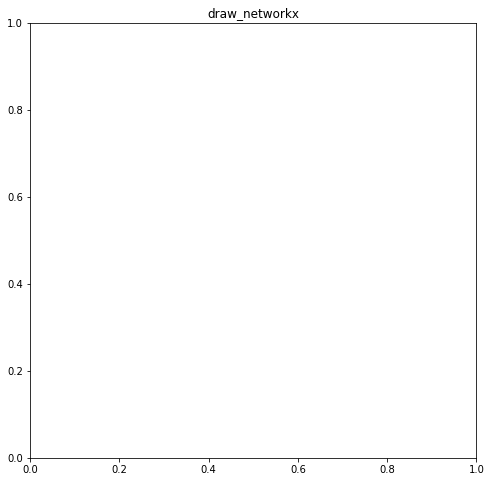

In [261]:
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
#import matplotlib.pyplot as plt
G = nx.DiGraph()
for src, v in x.items():
    for dest, f in v.items():
        if f > 0:
            G.add_edge(src,dest,flow=f)

#for v in G.nodes():
#    G[v]['name']=v[:4]


#all nodes must have subset_key (default='subset') as data (can probably be used as distance in bfs)
#pos = nx.multipartite_layout(G)
fig = plt.figure(figsize=(8,8))

#write_dot(G,'test.dot')

# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos =graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, arrows=True)

pos = nx.spectral_layout(G)
nx.draw(G, pos=pos) 
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
#plt.savefig('this.png')
plt.show()
"""
#nx.draw(G, pos)
node_labels = nx.get_node_attributes(G,'name')
nx.draw_networkx_labels(G, pos, labels = node_labels)
edge_labels = nx.get_edge_attributes(G,'flow')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
#plt.savefig('this.png')
plt.show()"""

In [69]:
x = generate_null_flow(G)
print(compute_cost(G,x))
x["S"]["A"]=2
x["A"]["B"]=2
x["B"]["D"]=2
print(compute_cost(G,x))

x = generate_null_flow(G)
print(compute_cost(G,x))
x["S"]["A"]=1
x["A"]["B"]=1
x["B"]["D"]=1
x["S"]["X"]=1
x["X"]["Y"]=1
x["Y"]["D"]=1
print(compute_cost(G,x))



0.0
3.9068905956085183
0.0
3.0064262691594323


In [206]:

x = generate_null_flow(G)
pi = {n:0 for n in G.nodes}
R = compute_delta_residual_network(G,x,2,pi)
print_residual(R,G,x)

x["S"]["A"]=2
x["A"]["B"]=2
x["B"]["D"]=2

"""
pi["S"]-=0
pi["A"]-=R["S"]["A"][0]["rc"]
pi["B"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"]
pi["X"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"] + R["B"]["X"][0]["rc"]
pi["Y"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"] + R["B"]["X"][0]["rc"] + R["X"]["Y"][0]["rc"]
pi["D"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"] + R["B"]["D"][0]["rc"]
"""
print(paths["D"])
distances, paths = nx.single_source_dijkstra(R,"S",weight="rc")
            #distances, paths = nx.single_source_bellman_ford(R,k,weight="rc")
            #####print("Distances from {}".format(k))
for n, d_value in distances.items():
                #####print(n,d_value)
                #if n in pi:
    pi[n]-=d_value

#add hoc because known for our data set
e = {n:0 for n in G.nodes}
print(pi)

print(x)
R = compute_delta_residual_network(G,x,1,pi)
print("\n1-residual network after 2 flow S A B D")
print_residual(R,G,x)

fulfill_reduced_cost_optimiality_rule(R,x,e,1)
print_residual(R,G,x)
r = get_unsaturated_residual_subgraph(R)
print_residual(r,G,x)
print(e)
print(x)

distances, paths = nx.single_source_dijkstra(r,"X",weight="rc")
for n, d_value in distances.items():
                #####print(n,d_value)
                #if n in pi:
    pi[n]-=d_value
path = paths["D"]

R = recompute_reduced_cost(R,pi)

augment_path(x,path,1,R)
r = get_unsaturated_residual_subgraph(R)
print_residual(r,G,x)

distances, paths = nx.single_source_dijkstra(r,"Y",weight="rc")
for n, d_value in distances.items():
                #####print(n,d_value)
                #if n in pi:
    pi[n]-=d_value

path = paths["B"]
augment_path(x,path,1,R)
print(x)

S A {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
A S {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
A B {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
B A {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
X B {0: {'uc': 0.1609640474436811, 'rc': 0.1609640474436811, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 9, 'k': 0}}
B X {0: {'uc': 0.1609640474436811, 'rc': 0.1609640474436811, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 9, 'k': 0}}
X Y {0: {'uc': 0.20751874963942196, 'rc': 0.20751874963942196, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 7, 'k': 0}}
Y X {0: {'uc': 0.20751874963942196, 'rc': 0.20751874963942196, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 7, 'k': 0}}
B D {0: {'uc': 0.36848279708310305, 'rc': 0.36848279708310305, 'flow': 0, 'c